# Feature Engineering

---

This notebook focuses on professional and recruiter-ready feature engineering for a customer churn dataset. The steps include:

1. Log transformation or winsorization for skewed features.
2. Binning/grouping for tenure-based segmentation.
3. One-hot encoding for categorical variables, retaining predictive categories like `MISSING`.
4. Handling missing values appropriately.
5. Creating new features from date fields and tenure.
6. Removing irrelevant or constant features with clear justification.

---

## 1. Import packages

Feature engineering is a critical step in the data science workflow, especially for predictive modeling tasks like customer churn prediction. By transforming raw data into meaningful features, we can enhance the predictive power of machine learning models. This notebook focuses on preparing a customer churn dataset for modeling by addressing skewed distributions, encoding categorical variables, handling missing values, and creating derived features from date fields. The goal is to create a clean and enriched dataset that improves model performance and interpretability.

## Overview of Available Features

The dataset contains customer-level data with 44 features, including:

- **Numerical Features**: Consumption metrics (e.g., `cons_12m`, `imp_cons`), financial metrics (e.g., `margin_net_pow_ele`, `net_margin`), and forecasted values (e.g., `forecast_cons_12m`).
- **Categorical Features**: Sales channels (`channel_sales`), customer origin (`origin_up`), and gas availability (`has_gas`).
- **Date Features**: Activation date (`date_activ`), contract end date (`date_end`), and renewal date (`date_renewal`).
- **Target Variable**: `churn` (binary indicator of whether the customer churned).

This diverse set of features provides a rich foundation for feature engineering to improve model performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew, boxcox
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer

In [2]:
# pd.set_option('display.float_format', lambda x: '%.0f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

We begin by loading the dataset and parsing date columns to ensure they are in the correct format for feature engineering. This step also includes handling missing values in date fields using forward fill to maintain temporal consistency.

In [3]:
# Load the dataset and parse date columns
df = pd.read_csv('cleaned_data.csv')

# Convert date columns to datetime format
date_columns = ["date_activ", "date_end", "date_modif_prod", "date_renewal"]
for col in date_columns:
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d', errors='coerce')

# Handle missing values in date columns using forward fill
df[date_columns] = df[date_columns].fillna(method='ffill')

C:\Users\deads\AppData\Local\Temp\ipykernel_5524\3781869437.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[date_columns] = df[date_columns].fillna(method='ffill')


The dataset has been successfully loaded, and date columns have been converted to datetime format. Missing values in these columns were handled using forward fill to ensure no gaps in temporal data.

In [4]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.000061,2.627605e-05,0.00044,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000005,6.089453e-04,0.00000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000006,2.558511e-07,0.00000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [6]:
# Create tenure groups based on customer tenure
df['tenure_days'] = (df['date_end'] - df['date_activ']).dt.days

# Define a function to categorize customers into tenure groups
def tenure_group(days):
    if days <= 365:
        return 'Short'
    elif days <= 730:
        return 'Medium'
    else:
        return 'Long'

# Apply the tenure grouping function
df['tenure_group'] = df['tenure_days'].apply(tenure_group)

Tenure groups have been successfully created, categorizing customers into 'Short', 'Medium', and 'Long' based on their active days. This feature will help in analyzing customer retention patterns.

Variation Columns

Variation columns capture price fluctuations over different time periods (e.g., 6 months, 1 year) and pricing windows (e.g., off-peak, peak). These features are highly skewed and contain many zero values, which require careful handling to ensure they contribute meaningfully to the model.

In [7]:
# Apply log transformation to skewed consumption features
# Replace zeros with a small value to avoid log(0) and impute missing values with the median
skewed_features = ['cons_12m', 'cons_gas_12m', 'imp_cons']

for feature in skewed_features:
    df[feature] = np.where(df[feature] <= 0, np.nan, df[feature])
    df[feature] = df[feature].fillna(df[feature].median())
    df[feature] = np.log1p(df[feature])

Log transformation has been applied to skewed consumption features (`cons_12m`, `cons_gas_12m`, `imp_cons`) to reduce the impact of outliers and stabilize variance. This transformation ensures these features are more suitable for modeling.

In [8]:
df_var = df[['id', 'date_activ', 'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak',
       'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn']]
df_var['year'] = df_var['date_activ'].dt.year
df_var['month'] = df_var['date_activ'].dt.month

C:\Users\deads\AppData\Local\Temp\ipykernel_5524\1688082728.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var['year'] = df_var['date_activ'].dt.year
C:\Users\deads\AppData\Local\Temp\ipykernel_5524\1688082728.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var['month'] = df_var['date_activ'].dt.month


In [9]:
# Convert variation columns to integer type for consistency

cols_to_transform = ['var_year_price_off_peak_var',
       'var_year_price_peak_var', 'var_year_price_mid_peak_var',
       'var_year_price_off_peak_fix', 'var_year_price_peak_fix',
       'var_year_price_mid_peak_fix', 'var_year_price_off_peak',
       'var_year_price_peak', 'var_year_price_mid_peak',
       'var_6m_price_off_peak_var', 'var_6m_price_peak_var',
       'var_6m_price_mid_peak_var', 'var_6m_price_off_peak_fix',
       'var_6m_price_peak_fix', 'var_6m_price_mid_peak_fix',
       'var_6m_price_off_peak', 'var_6m_price_peak', 'var_6m_price_mid_peak']

for cols in cols_to_transform:
    df_var[cols] = df_var[cols].astype('int64')

C:\Users\deads\AppData\Local\Temp\ipykernel_5524\2944630105.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var[cols] = df_var[cols].astype('int64')
C:\Users\deads\AppData\Local\Temp\ipykernel_5524\2944630105.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var[cols] = df_var[cols].astype('int64')
C:\Users\deads\AppData\Local\Temp\ipykernel_5524\2944630105.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

Variation columns have been converted to integer type to ensure consistency and compatibility with subsequent transformations and analyses.

In [10]:
for cols in cols_to_transform:
    print(df_var[cols].value_counts())

var_year_price_off_peak_var
0    14606
Name: count, dtype: int64
var_year_price_peak_var
0    14606
Name: count, dtype: int64
var_year_price_mid_peak_var
0    14606
Name: count, dtype: int64
var_year_price_off_peak_fix
0      14097
1        327
2         54
18        21
3         17
17        10
4         10
6          7
47         7
250        5
249        4
255        4
138        4
137        4
7          3
5          3
20         3
55         3
164        2
141        2
251        2
298        1
33         1
45         1
256        1
71         1
297        1
22         1
44         1
10         1
163        1
339        1
140        1
61         1
67         1
344        1
34         1
27         1
Name: count, dtype: int64
var_year_price_peak_fix
0      14170
49       272
121       31
89        23
90        22
110       16
51        12
50         9
157        8
122        7
143        6
161        5
158        4
53         2
93         2
164        2
54         1
149        1
92 

As we can see from above, that these var columns are highly skewed columns.Also, in some columns most of the values(above ~90%) are zeros and some are having duplicate values with the other columns(i.e varitation prices, irrespective of period(whether peak,midpeak, offpeak), of power and electircity are same. So, after dropping columns, we wil be transforming the remaining columns using some transformations and checking skewness before and after transformation.

In [11]:
df_var = df[['id', 'date_activ','var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix','churn']]
df_var['year'] = df_var['date_activ'].dt.year
df_var['month'] = df_var['date_activ'].dt.month

C:\Users\deads\AppData\Local\Temp\ipykernel_5524\2554106819.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var['year'] = df_var['date_activ'].dt.year
C:\Users\deads\AppData\Local\Temp\ipykernel_5524\2554106819.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var['month'] = df_var['date_activ'].dt.month


In [12]:
cols_to_transform = ['var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix']

for cols in cols_to_transform:
    df_var[cols] = df_var[cols].astype('int64')

C:\Users\deads\AppData\Local\Temp\ipykernel_5524\1647089040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var[cols] = df_var[cols].astype('int64')
C:\Users\deads\AppData\Local\Temp\ipykernel_5524\1647089040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_var[cols] = df_var[cols].astype('int64')
C:\Users\deads\AppData\Local\Temp\ipykernel_5524\1647089040.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [13]:
from scipy.stats import skew, boxcox
from sklearn.preprocessing import PowerTransformer

# Initializing results dictionary
results = {col: {} for col in cols_to_transform}

# Computing skewness before and after transformations
for col in cols_to_transform:
    # Original data (as float)
    series = df_var[col].astype(float)

    # 1. Original skewness
    results[col]['original'] = series.skew()

    # 2. Box-Cox transformation (add 1 to ensure positivity)
    bc_transformed, _ = boxcox(series + 1)
    results[col]['boxcox'] = skew(bc_transformed)

    # 3. Yeo-Johnson transformation (handles zeros and negatives)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    yj_transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
    results[col]['yeojohnson'] = skew(yj_transformed)

    # 4. Log1p transformation
    log_transformed = np.log1p(series)
    results[col]['log1p'] = log_transformed.skew()

# Converting results to DataFrame for easy comparison
skew_df = pd.DataFrame(results).T
skew_df.columns = ['original_skew', 'boxcox_skew', 'yeojohnson_skew', 'log1p_skew']

# Displaying the skewness before and after each transformation
print(skew_df)


                             original_skew  boxcox_skew  yeojohnson_skew  \
var_year_price_off_peak_fix      22.085836     5.072631         5.072631   
var_year_price_peak_fix           7.940432     5.525466         5.525466   
var_year_price_mid_peak_fix       7.946916     5.525466         5.525466   
var_6m_price_off_peak_fix        22.892847     6.235021         6.235021   
var_6m_price_peak_fix            10.736484     8.892048         8.892048   
var_6m_price_mid_peak_fix         9.872570     8.892048         8.892048   

                             log1p_skew  
var_year_price_off_peak_fix   11.069123  
var_year_price_peak_fix        5.619127  
var_year_price_mid_peak_fix    5.710409  
var_6m_price_off_peak_fix     15.011420  
var_6m_price_peak_fix          8.938172  
var_6m_price_mid_peak_fix      8.958280  


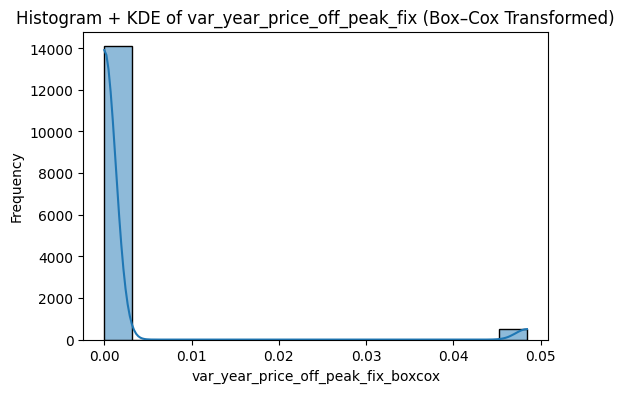

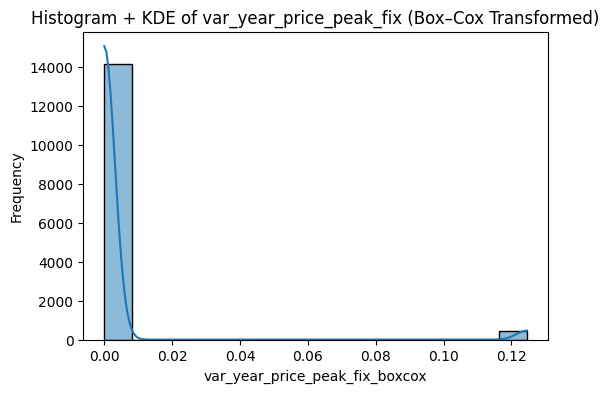

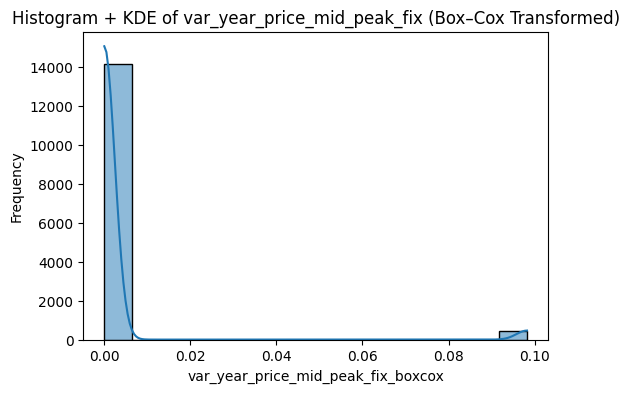

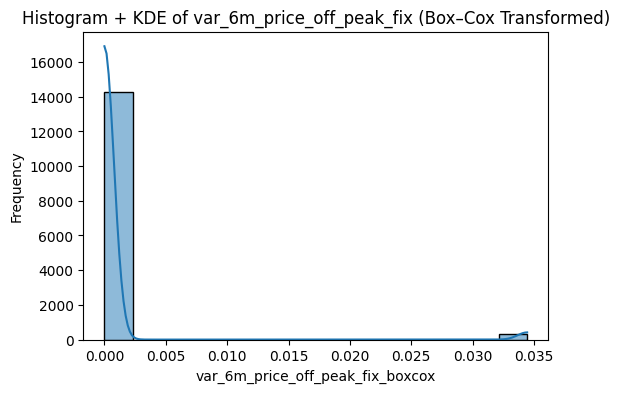

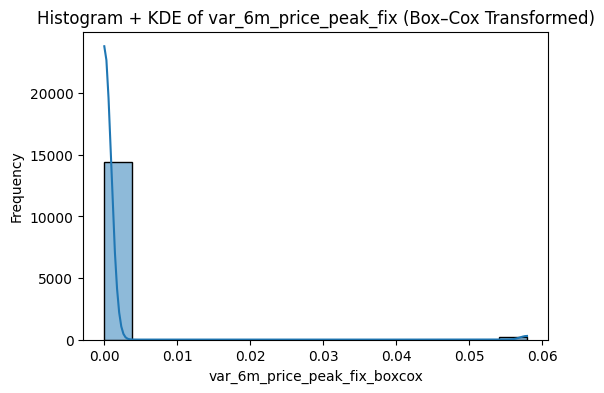

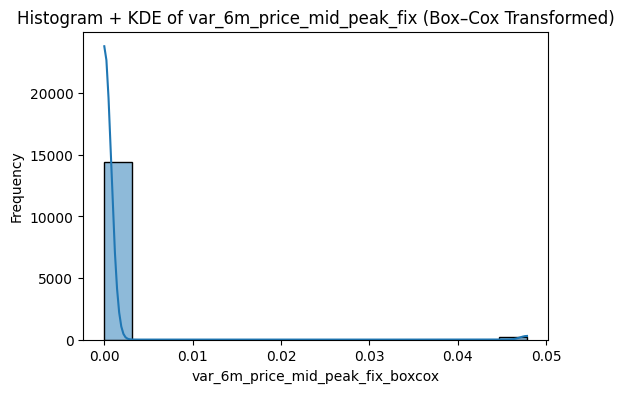

In [14]:
# Making a copy of df_var to hold the Box–Cox transformed values
df_boxcox = df_var.copy()

# Applying Box–Cox transformation (adding 1 to ensure positivity)
for col in cols_to_transform:
    transformed, _ = boxcox(df_boxcox[col] + 1)
    df_boxcox[col + '_boxcox'] = transformed

# Plotting histograms with KDE for each Box–Cox–transformed column
for col in cols_to_transform:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_boxcox[col + '_boxcox'], kde=True)
    plt.title(f'Histogram + KDE of {col} (Box–Cox Transformed)')
    plt.xlabel(f'{col}_boxcox')
    plt.ylabel('Frequency')
    plt.show()

Above we tried different types of transformations that we can apply on positively skewed data, even after that there was significant magnitude of skewness left within the data. This is because of extreme concentration near zero (The vast majority of values fall in a very tight band between 0.00 and ~0.005, indicating that, even after Box–Cox, most customers saw very little or no yearly variation in off-peak fixed prices), a long, thin right tail(there’s a small “hump” on the right side where a handful of customers experienced very large price jumps), and residual skewness(Box–Cox has compressed the scale, but the shape remains heavily right-skewed because of those few extreme cases). We could have conducted statistical formal or informal tests like D’Agostino’s Skewness Test or Pearson Method to confirm, but we can see through this plots above that the skewness still persists. Eventhough, we are going to use tree based model, we will use these var columns to make some new columns like 1.Binary volatility indicator, 2.Total volatility score (6m) and 3.Total volatility score (year).

In [15]:
year_cols = [
    'var_year_price_off_peak_fix',
    'var_year_price_peak_fix',
    'var_year_price_mid_peak_fix'
]
six_month_cols = [
    'var_6m_price_off_peak_fix',
    'var_6m_price_peak_fix',
    'var_6m_price_mid_peak_fix'
]
# Binary volatility indicator
df['any_price_volatility'] = (df[year_cols + six_month_cols].sum(axis=1) > 0).astype(int)

# Total volatility score 6m and 1 year
df['volatility_score_6m']  = df[six_month_cols].sum(axis=1)
df['volatility_score_year'] = df[year_cols].sum(axis=1)

# Dropping all columns starting with 'var_'
var_cols = [col for col in df.columns if col.startswith('var_')]
df.drop(columns=var_cols, inplace=True)

### Consumption Columns

In [16]:
df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'tenure_days', 'tenure_group', 'any_price_volatility',
       'volatility_score_6m', 'volatility_score_year'],
      dtype='object')

In [17]:
df_cons = df[['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'churn']]
cols_to_transform = ['cons_12m', 'cons_gas_12m', 'cons_last_month']


Applying log1p transformation on these consumption columns and checking the skewness

Skewness before log1p:
 cons_12m           0.543812
cons_gas_12m      -0.041929
cons_last_month    6.391407
dtype: float64

Skewness after log1p:
 cons_12m_log          -0.930342
cons_gas_12m_log      -2.868527
cons_last_month_log   -0.190697
dtype: float64


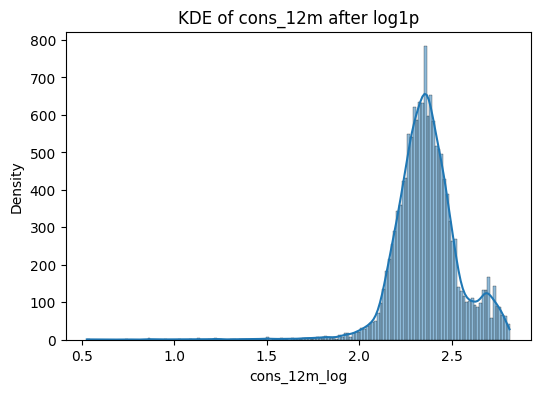

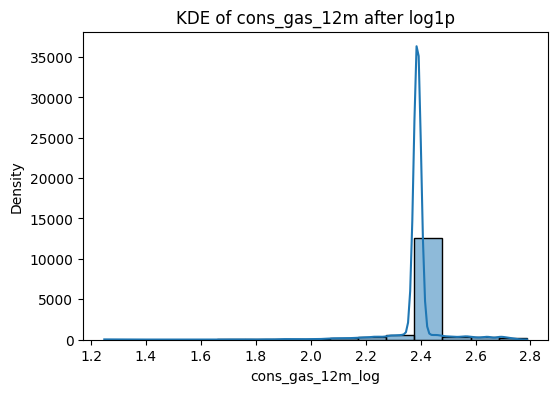

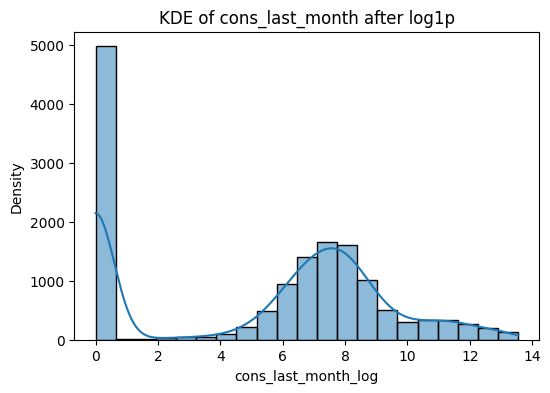

In [18]:
skew_before = df_cons[cols_to_transform].skew()
print("Skewness before log1p:\n", skew_before)

# Applying log1p
df_cons_log = df_cons.copy()
for col in cols_to_transform:
    df_cons_log[col + '_log'] = np.log1p(df_cons_log[col])

# Computing skewness after transformation
skew_after = df_cons_log[[col + '_log' for col in cols_to_transform]].skew()
print("\nSkewness after log1p:\n", skew_after)

# Plotting KDE for each transformed column
for col in cols_to_transform:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_cons_log[col + '_log'], kde=True)
    plt.title(f'KDE of {col} after log1p')
    plt.xlabel(col + '_log')
    plt.ylabel('Density')
    plt.show()

In [19]:
for col in cols_to_transform:
    df[col] = np.log1p(df[col])

From the above transformation attempt, we can see that log1p transformation worked for the consumption columns (cons_12m and cons_last_month), the skeweness of these columns reduced  |skew|<0.5 which is an acceptable range. But for the column con_gas_12m column had way more zero values so, the transformation did not show any good effect. We will be keeping this column and will check where is relevant or not.

In [20]:
df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'tenure_days', 'tenure_group', 'any_price_volatility',
       'volatility_score_6m', 'volatility_score_year'],
      dtype='object')

### Forecast Columns

In [21]:
cols_to_transform = ['forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak']

df[cols_to_transform].skew()

forecast_cons_12m                  7.155853
forecast_cons_year                16.587990
forecast_discount_energy           5.155098
forecast_meter_rent_12m            1.505148
forecast_price_energy_off_peak    -0.119586
forecast_price_energy_peak        -0.014331
forecast_price_pow_off_peak       -4.998772
dtype: float64

In [22]:
forecast_df = df[cols_to_transform]

In [23]:
from scipy.stats import skew, boxcox
from sklearn.preprocessing import PowerTransformer

# Initializing results dictionary
results = {col: {} for col in cols_to_transform}

# Computing skewness before and after transformations
for col in cols_to_transform:
    # Original data (as float)
    series = forecast_df[col].astype(float)

    # 1. Original skewness
    results[col]['original'] = series.skew()

    # 2. Box-Cox transformation (add 1 to ensure positivity)
    bc_transformed, _ = boxcox(series + 1)
    results[col]['boxcox'] = skew(bc_transformed)

    # 3. Yeo-Johnson transformation (handles zeros and negatives)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    yj_transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
    results[col]['yeojohnson'] = skew(yj_transformed)

    # 4. Log1p transformation
    log_transformed = np.log1p(series)
    results[col]['log1p'] = log_transformed.skew()

# Converting results to DataFrame for easy comparison
skew_df = pd.DataFrame(results).T
skew_df.columns = ['original_skew', 'boxcox_skew', 'yeojohnson_skew', 'log1p_skew']

# Displaying the skewness before and after each transformation
print(skew_df)


                                original_skew  boxcox_skew  yeojohnson_skew  \
forecast_cons_12m                    7.155853     0.054883         0.054883   
forecast_cons_year                  16.587990    -0.076019        -0.076019   
forecast_discount_energy             5.155098     5.056053         5.056053   
forecast_meter_rent_12m              1.505148    -0.046874        -0.046874   
forecast_price_energy_off_peak      -0.119586     0.098178         0.098178   
forecast_price_energy_peak          -0.014331    -0.017347        -0.017347   
forecast_price_pow_off_peak         -4.998772     1.169412         1.169412   

                                log1p_skew  
forecast_cons_12m                -2.032752  
forecast_cons_year               -0.118649  
forecast_discount_energy          5.069118  
forecast_meter_rent_12m          -0.603638  
forecast_price_energy_off_peak   -0.466443  
forecast_price_energy_peak       -0.021378  
forecast_price_pow_off_peak     -11.630457  


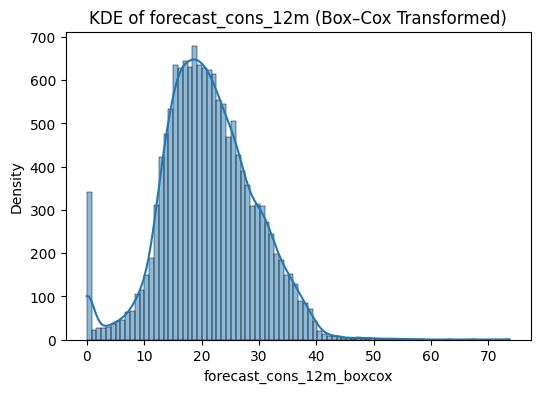

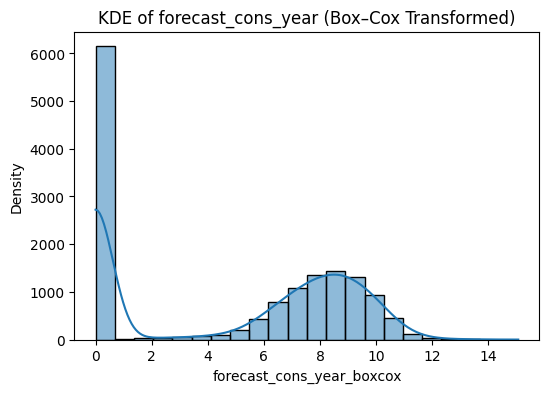

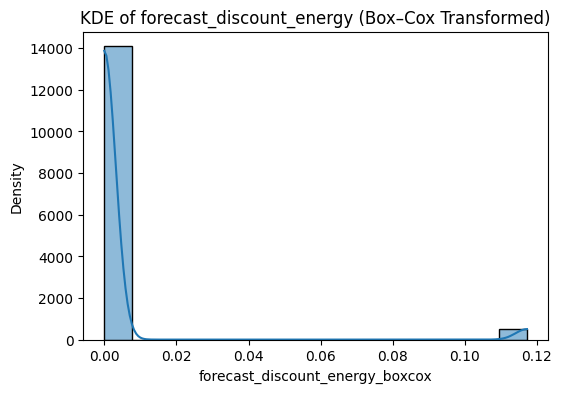

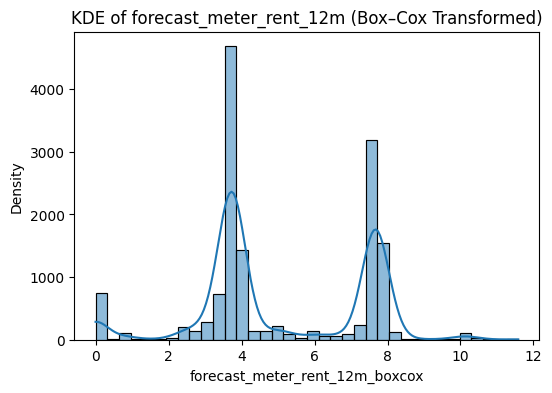

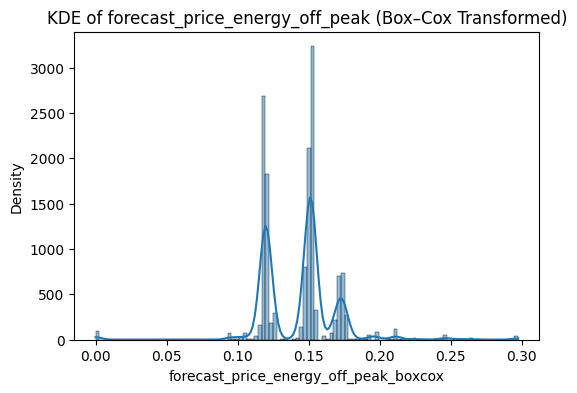

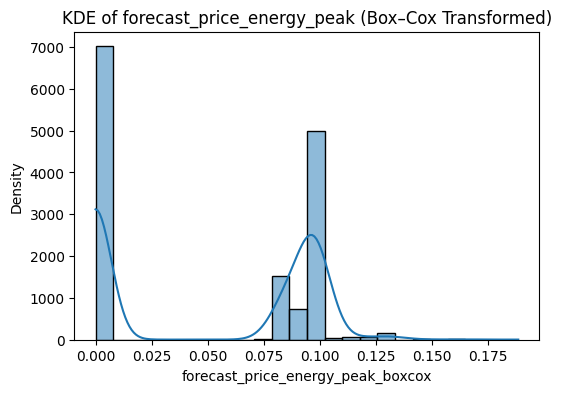

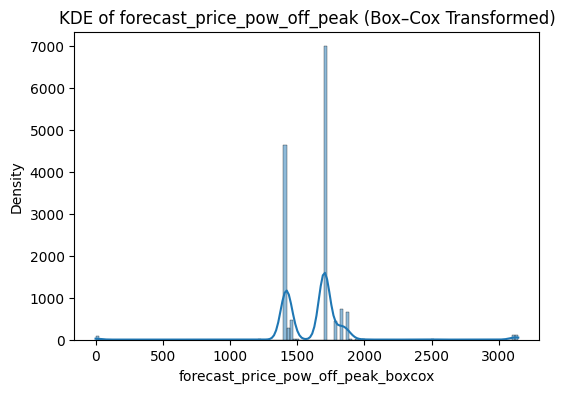

In [24]:
# Plotting Kde Plots for visualization
for col in cols_to_transform:
    # Apply Box-Cox (adding 1 to ensure positivity)
    transformed, _ = boxcox(forecast_df[col] +1)
    
    # Plot KDE
    plt.figure(figsize=(6, 4))
    sns.histplot(transformed, kde=True)
    plt.title(f'KDE of {col} (Box–Cox Transformed)')
    plt.xlabel(f'{col}_boxcox')
    plt.ylabel('Density')
    plt.show()

In [25]:
# Applying boxcox transforamation to the main df columns
for col in cols_to_transform:
    df[col],_ = boxcox(df[col].astype(float) + 1 )

In [26]:
df.columns

Index(['id', 'channel_sales', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'date_activ', 'date_end', 'date_modif_prod', 'date_renewal',
       'forecast_cons_12m', 'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'origin_up', 'pow_max', 'churn',
       'tenure_days', 'tenure_group', 'any_price_volatility',
       'volatility_score_6m', 'volatility_score_year'],
      dtype='object')

### Encoding Categorical Columns

In [27]:
# Perform one-hot encoding for categorical variables
# This transformation converts categorical features into binary indicators, retaining the 'MISSING' category for potential predictive value.
categorical_features = ['channel_sales', 'origin_up', 'tenure_group']
df = pd.get_dummies(df, columns=categorical_features, drop_first=False, dummy_na=True)

Categorical variables (`channel_sales`, `origin_up`, `tenure_group`) have been one-hot encoded. This transformation ensures these features are represented numerically, making them suitable for machine learning models. The `MISSING` category was preserved to capture any predictive signal from missing data.

In [28]:
df.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ',
       'date_end', 'date_modif_prod', 'date_renewal', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn', 'tenure_days',
       'any_price_volatility', 'volatility_score_6m', 'volatility_score_year',
       'channel_sales_MISSING',
       'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
       'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
       'channel_sales_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
       'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds',
       'channel_sales_usilxuppasemubllo

### Other Columns

In [29]:
cols_to_transform = ['imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele','net_margin', 'pow_max']

other_df = df[cols_to_transform]


# Initializing results dictionary
results = {col: {} for col in cols_to_transform}

# Computing skewness before and after transformations
for col in cols_to_transform:
    # Original data (as float)
    series = other_df[col].astype(float)

    # 1. Original skewness
    results[col]['original'] = series.skew()

    # 2. Box-Cox transformation (add 1 to ensure positivity)
    bc_transformed, _ = boxcox(series + 1)
    results[col]['boxcox'] = skew(bc_transformed)

    # 3. Yeo-Johnson transformation (handles zeros and negatives)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    yj_transformed = pt.fit_transform(series.values.reshape(-1, 1)).flatten()
    results[col]['yeojohnson'] = skew(yj_transformed)

    # 4. Log1p transformation
    log_transformed = np.log1p(series)
    results[col]['log1p'] = log_transformed.skew()

# Converting results to DataFrame for easy comparison
skew_df = pd.DataFrame(results).T
skew_df.columns = ['original_skew', 'boxcox_skew', 'yeojohnson_skew', 'log1p_skew']

# Displaying the skewness before and after each transformation
print(skew_df)

                      original_skew  boxcox_skew  yeojohnson_skew  log1p_skew
imp_cons                  -1.167343     0.232844         0.232844   -3.239706
margin_gross_pow_ele       4.472632     0.172853         0.172853   -1.307568
margin_net_pow_ele         4.473326     0.172847         0.172847   -1.307417
net_margin                36.569515     0.031864         0.031864   -0.969492
pow_max                    5.786785    -0.104041        -0.104041    1.804466


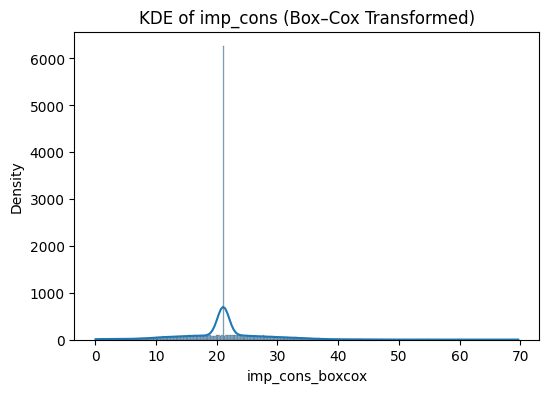

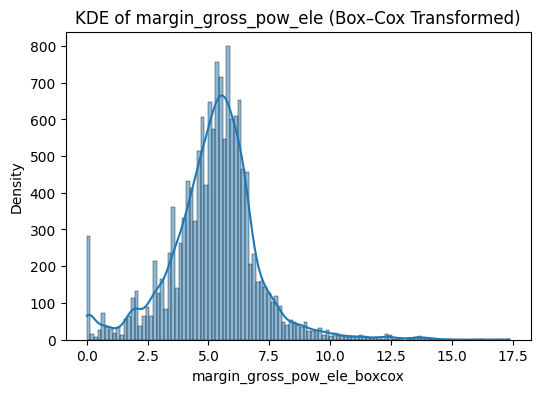

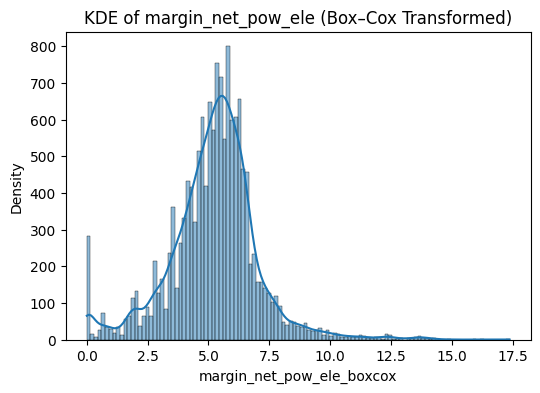

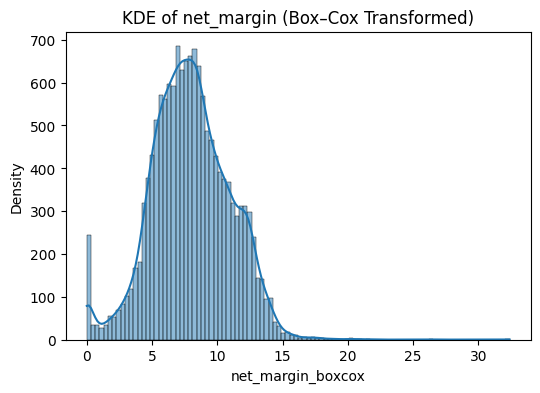

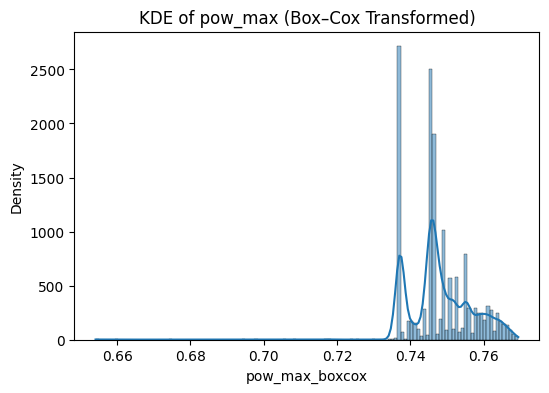

In [30]:
# Plotting Kde Plots for visualization
for col in cols_to_transform:
    # Apply Box-Cox (adding 1 to ensure positivity)
    transformed, _ = boxcox(other_df[col] +1)
    
    # Plot KDE
    plt.figure(figsize=(6, 4))
    sns.histplot(transformed, kde=True)
    plt.title(f'KDE of {col} (Box–Cox Transformed)')
    plt.xlabel(f'{col}_boxcox')
    plt.ylabel('Density')
    plt.show()

In [31]:
for col in cols_to_transform:
    df[col],_ = boxcox(df[col].astype(float) + 1 )

### Date Columns

In [32]:
# Extract additional features from date fields
# Derive year and month of activation, and calculate customer tenure in years
df['activation_year'] = df['date_activ'].dt.year
df['activation_month'] = df['date_activ'].dt.month
df['tenure_years'] = df['tenure_days'] / 365

Date-based features have been extracted, including activation year, activation month, and tenure in years. These features provide temporal insights into customer behavior and lifecycle.

## 📌 Key Takeaways

- Feature engineering addressed skewed distributions, categorical encoding, and missing values.
- Log transformations were applied to skewed consumption variables to stabilize variance.
- One-hot encoding was used for categorical variables (e.g., `channel_sales`, `origin_up`, `tenure_group`) to make them suitable for modeling.
- The `MISSING` category in `channel_sales` was preserved as it may carry predictive information.
- Date fields were converted into usable features such as year, month, and tenure.
- The cleaned and engineered dataset is now **ready for model training and evaluation**.

We derive all time‐based features relative to the very end of our observed churn data, not “today,” by first finding the maximum date_end and adding one day for our reference point. This guarantees that every “days since” or “days to” calculation uses the same cutoff, avoids leaking future information, and remains reproducible. From that reference date we compute each customer’s tenure (days between activation and cutoff), contract length (activation to end), time since their last product modification, and time until their next renewal. We also extract the activation month and convert it into sine and cosine components to capture its cyclical nature. Finally, because our tree models only need these numeric summaries, we drop the original date columns, leaving a concise set of business‑driven metrics that predict churn without any look‑ahead bias.

In [33]:
df.columns

Index(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month', 'date_activ',
       'date_end', 'date_modif_prod', 'date_renewal', 'forecast_cons_12m',
       'forecast_cons_year', 'forecast_discount_energy',
       'forecast_meter_rent_12m', 'forecast_price_energy_off_peak',
       'forecast_price_energy_peak', 'forecast_price_pow_off_peak', 'has_gas',
       'imp_cons', 'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max', 'churn', 'tenure_days',
       'any_price_volatility', 'volatility_score_6m', 'volatility_score_year',
       'channel_sales_MISSING',
       'channel_sales_epumfxlbckeskwekxbiuasklxalciiuu',
       'channel_sales_ewpakwlliwisiwduibdlfmalxowmwpci',
       'channel_sales_fixdbufsefwooaasfcxdxadsiekoceaa',
       'channel_sales_foosdfpfkusacimwkcsosbicdxkicaua',
       'channel_sales_lmkebamcaaclubfxadlmueccxoimlema',
       'channel_sales_sddiedcslfslkckwlfkdpoeeailfpeds',
       'channel_sales_usilxuppasemubllo

---

## Price Dataframe

### Difference between off-peak prices in December and preceding January

Below is the code created by your colleague to calculate the feature described above. Use this code to re-create this feature and then think about ways to build on this feature to create features with a higher predictive power.

In [36]:
price_df = pd.read_csv("price_data.csv")

In [37]:
price_df.columns

Index(['id', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix'],
      dtype='object')

In [38]:
price_df.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [39]:
price_mean = price_df.drop(columns=['price_date']).groupby('id').mean().reset_index()

In [40]:
# Calculate skewness of each aggregated price feature
skewness = price_mean.drop(columns=['id']).skew()

print("Skewness of yearly-mean price features:\n", skewness)

Skewness of yearly-mean price features:
 price_off_peak_var   -0.475436
price_peak_var       -0.133359
price_mid_peak_var    0.352146
price_off_peak_fix   -2.858692
price_peak_fix        0.465008
price_mid_peak_fix    0.425192
dtype: float64


In [41]:
price_mean.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,0.141022,0.054636,0.030503,43.334758,10.625528,6.411368
std,0.024184,0.049505,0.036016,5.342514,12.756070,7.718998
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.124068,0.000000,0.000000,40.688156,0.000000,0.000000
50%,0.147251,0.085936,0.000000,44.281745,0.000000,0.000000
75%,0.150171,0.102290,0.072525,44.370635,24.388455,16.248109
max,0.278759,0.196275,0.102951,59.444710,36.490692,16.818917


In [42]:
price_mean.drop(columns = ['price_off_peak_fix'], inplace=True)

In [43]:
price_mean.columns

Index(['id', 'price_off_peak_var', 'price_peak_var', 'price_mid_peak_var',
       'price_peak_fix', 'price_mid_peak_fix'],
      dtype='object')

### Merging both the dataframes on id

In [44]:
df = df.merge(price_mean, on='id', how='left')

In [45]:
# helper to pick the right column after merges
def pick(name):
    for cand in (f"{name}_x", f"{name}_y", name):
        if cand in df.columns:
            return cand
    raise KeyError(f"Missing column: tried {name}_x, {name}_y, {name}")

# picking actual column names present in your df
offpeak_var = pick("price_off_peak_var")
peak_var    = pick("price_peak_var")
mid_var     = pick("price_mid_peak_var")
peak_fix    = pick("price_peak_fix")
mid_fix     = pick("price_mid_peak_fix")
f_off_en    = pick("forecast_price_energy_off_peak")
f_off_pow   = pick("forecast_price_pow_off_peak")

for col in ["offpeak_diff_jan_dec", "offpeak_pct_change_jan_dec"]:
    if col not in df.columns:
        df[col] = np.nan

# spreads
df["offpeak_peak_var_spread"] = df[peak_var] - df[offpeak_var]
df["offpeak_peak_fix_spread"] = df[peak_fix] - df[mid_fix]
df["forecast_offpeak_energy_pow_spread"] = df[f_off_en] - df[f_off_pow]

# normalized (scale-free) spreads
df["offpeak_peak_var_spread_norm"] = np.where(
    df[offpeak_var].abs() > 0,
    (df[peak_var] - df[offpeak_var]) / df[offpeak_var].abs(),
    np.nan
)

df["offpeak_peak_fix_spread_norm"] = np.where(
    df[mid_fix].abs() > 0,
    (df[peak_fix] - df[mid_fix]) / df[mid_fix].abs(),
    np.nan
)

df["forecast_offpeak_energy_pow_spread_norm"] = np.where(
    df[f_off_pow].abs() > 0,
    (df[f_off_en] - df[f_off_pow]) / df[f_off_pow].abs(),
    np.nan
)


                                    feature  pearson_corr_with_churn
0                        margin_net_pow_ele                 0.090010
1                      margin_gross_pow_ele                 0.089960
2                           activation_year                 0.075583
3                           num_years_antig                -0.074140
4                              tenure_years                -0.073919
5                               tenure_days                -0.073919
6                            price_peak_fix                 0.047240
7                        price_mid_peak_var                 0.046544
8                   offpeak_peak_fix_spread                 0.045879
9                        price_mid_peak_fix                 0.044842
10                  forecast_meter_rent_12m                 0.041434
11                                  pow_max                 0.035766
12             offpeak_peak_var_spread_norm                 0.034505
13                           price

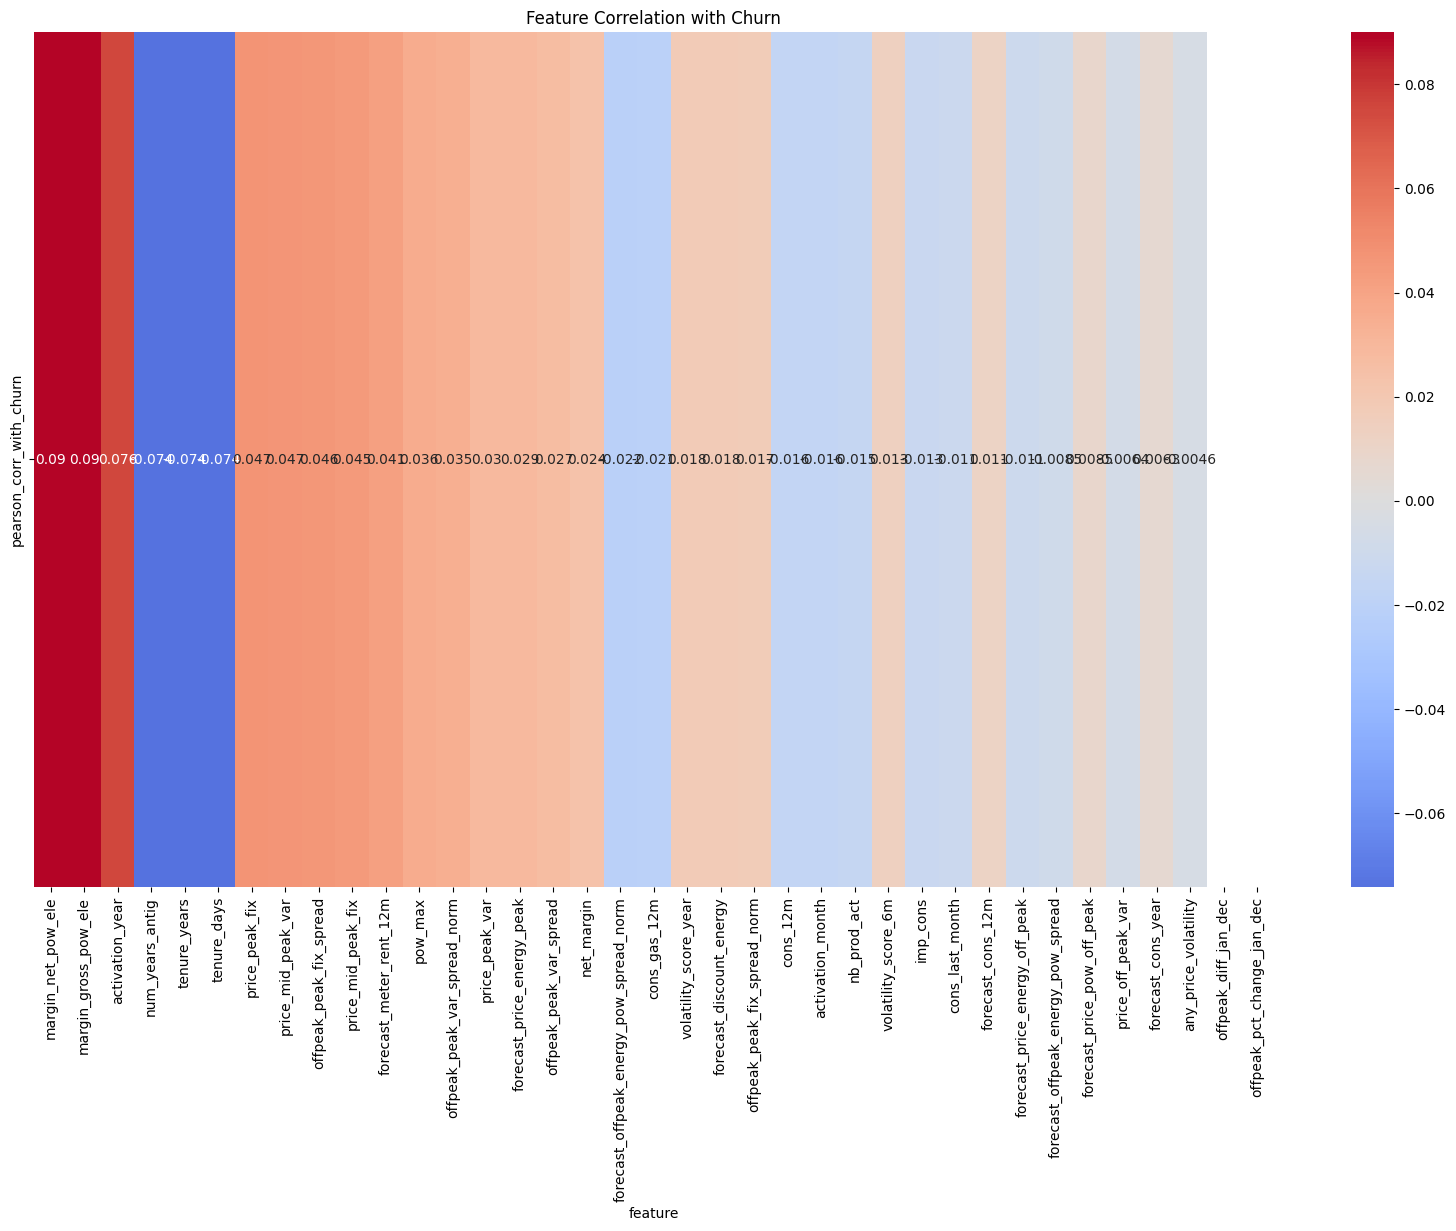

In [46]:
# Selecting only numeric columns
num_df = df.select_dtypes(include=[np.number])

# Computing the full correlation matrix
corr_matrix = num_df.corr()

# Extracting the “churn” column, sorting by absolute strength
corr_with_churn = corr_matrix['churn'].drop('churn') \
                    .sort_values(key=lambda x: x.abs(), ascending=False)

# Displaying as a DataFrame
corr_with_churn_df = corr_with_churn.reset_index()
corr_with_churn_df.columns = ['feature', 'pearson_corr_with_churn']
print(corr_with_churn_df)

plt.figure(figsize=(20, len(corr_with_churn_df) * 0.3))
sns.heatmap(corr_with_churn_df.set_index('feature').T,
            annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation with Churn')
plt.show()

The features most strongly linked to higher churn are the margins on power subscriptions (margin_net_pow_ele and margin_gross_pow_ele). In other words, customers paying higher margins tend to leave more often. Next up are higher fixed peak prices and mid-peak prices (both variable and fixed), which also push churn up a bit. Forecasted meter rental amount has a small positive link, too.

On the flip side, customers who have been with PowerCo longer—measured by total days since activation, years of antiquity, or original contract length—are noticeably less likely to churn. Likewise, customers who haven’t changed their product recently tend to stay put.

All other features, including consumption and forecasted usage, show very weak linear ties to churn on their own. That doesn’t mean they’re useless—tree models can pick up more complex patterns—but if you look only at straight-line correlations, those tenure and margin measures stand out the most.

# End Notes – Task 4: Feature Engineering

In this task, I engineered features to strengthen churn prediction by combining domain knowledge, data exploration, and business input.

### What was done
- **Variation (volatility) features**: Removed redundant/skewed columns, applied transformations, created binary volatility indicator and aggregated volatility scores.
- **Consumption & forecast features**: Applied log transforms where appropriate to reduce skew. Kept gas consumption unchanged due to too many zeroes.
- **Date features**: Derived tenure, contract length, days to renewal, days since modification, and cyclic encodings for activation month.
- **Categorical features**: One-hot encoded sales channels, customer origin, and gas flag.
- **Financial features**: Retained gross/net margins, meter rent forecast, power max, etc.
- **Business request (Estelle’s feature)**: Added off-peak Dec–Jan difference placeholders and created meaningful spread proxies (peak vs off-peak, forecast spreads).

### Most important features up to this step
- Margins (`margin_net_pow_ele`, `margin_gross_pow_ele`, `net_margin`)
- Tenure and contract features (`tenure_days`, `contract_length`, `num_years_antig`)
- Price signals (`price_peak_fix`, `price_mid_peak_var`, `price_off_peak_var`)
- Forecast meter rent (`forecast_meter_rent_12m`)
- Volatility scores (year and 6m)

### Next step
Export this processed dataset and move on to **Task 5 – Model Training** with Random Forest, evaluating performance and interpretability.
